In [2]:
import pandas as pd

df_ca = pd.read_excel("CA_Parts_Sales_Data _202503.xlsx")  # update filename if needed


In [3]:
df_ca.info()
df_ca.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13819 entries, 0 to 13818
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   sales_order_id          13819 non-null  int64         
 1   item_number             13819 non-null  object        
 2   helper_sales            13819 non-null  object        
 3   move_code               13819 non-null  int64         
 4   item_description        13819 non-null  object        
 5   uom                     13819 non-null  object        
 6   ordered_qty             13819 non-null  int64         
 7   dispatch_date           13819 non-null  datetime64[ns]
 8   wh_dispatch_date        13819 non-null  datetime64[ns]
 9   requested_ship_date     13819 non-null  datetime64[ns]
 10  deliver_remainder_flag  13819 non-null  int64         
 11  net_amount              13819 non-null  float64       
 12  currency_code           13819 non-null  object

Index(['sales_order_id', 'item_number', 'helper_sales', 'move_code',
       'item_description', 'uom', 'ordered_qty', 'dispatch_date',
       'wh_dispatch_date', 'requested_ship_date', 'deliver_remainder_flag',
       'net_amount', 'currency_code', 'shipped_qty', 'so_creation_date',
       'so_to_dispatch_days', 'order_month', 'warehouse_code'],
      dtype='object')

In [4]:
df_ca.head()


,sales_order_id,item_number,helper_sales,move_code,item_description,uom,ordered_qty,dispatch_date,wh_dispatch_date,requested_ship_date,deliver_remainder_flag,net_amount,currency_code,shipped_qty,so_creation_date,so_to_dispatch_days,order_month,warehouse_code
0,20006583,54850710R1,20006583|54850710R1,98,AXLE,pcs,1,2023-01-13,2023-01-13,2022-10-20,0,17757.79,CAD,1,2023-01-13 10:59:05,0,2023-01,20SPSU
1,20006616,100132298,20006616|100132298,97,CHARGING VALVE,pcs,1,2023-12-22,2023-02-02,2023-12-22,0,3044.61,CAD,1,2023-02-02 13:39:18,0,2023-02,20SPSU
2,20006879,52200037,20006879|52200037,97,"WASHER STZN HV200, M8, DIN 125 / ISO 7089",pcs,12,2023-01-17,2023-02-08,2022-12-28,0,38.76,CAD,12,2023-01-17 09:01:48,16,2023-01,20SPSU
3,20007011,54850573C1,20007011|54850573C1,98,AXLE,pcs,1,2023-06-07,2023-07-19,2022-12-05,0,2120.00,CAD,1,2023-06-07 10:12:21,30,2023-06,20SPSU
4,20007147,56070444,20007147|56070444,98,BALL VALVE,pcs,1,2023-01-04,2023-01-05,2023-01-04,0,18.61,CAD,1,2023-01-03 14:27:07,2,2023-01,20SPSU


In [5]:
import pandas as pd

def calculate_sla_deadline_ca(so_date: pd.Timestamp) -> pd.Timestamp:
    return so_date + pd.Timedelta(days=2)

df_ca["sla_deadline"] = df_ca["so_creation_date"].apply(calculate_sla_deadline_ca)
df_ca["sla_met"] = df_ca["wh_dispatch_date"] <= df_ca["sla_deadline"]

df_ca["year"] = df_ca["wh_dispatch_date"].dt.year
df_ca["month"] = df_ca["wh_dispatch_date"].dt.month
df_ca["year_month"] = df_ca["wh_dispatch_date"].dt.to_period("M").astype(str)


In [6]:
df_ca[["so_creation_date","wh_dispatch_date","sla_deadline","sla_met"]].head()


,so_creation_date,wh_dispatch_date,sla_deadline,sla_met
0,2023-01-13 10:59:05,2023-01-13,2023-01-15 10:59:05,True
1,2023-02-02 13:39:18,2023-02-02,2023-02-04 13:39:18,True
2,2023-01-17 09:01:48,2023-02-08,2023-01-19 09:01:48,False
3,2023-06-07 10:12:21,2023-07-19,2023-06-09 10:12:21,False
4,2023-01-03 14:27:07,2023-01-05,2023-01-05 14:27:07,True


In [7]:
analysis_ca = df_ca[
    (df_ca["wh_dispatch_date"] >= "2023-01-01") &
    (df_ca["wh_dispatch_date"] <= "2025-03-31") &
    (df_ca["move_code"].isin([1, 2, 3]))
].copy()


In [9]:
ca_yearly_avg_so = (
    analysis_ca
    .assign(year_so=analysis_ca["so_creation_date"].dt.year)
    .groupby(["year_so","move_code"])["so_to_dispatch_days"]
    .mean()
    .unstack("move_code")
    .round(2)
)

ca_yearly_avg_so["Avg"] = (
    analysis_ca
    .assign(year_so=analysis_ca["so_creation_date"].dt.year)
    .groupby("year_so")["so_to_dispatch_days"]
    .mean()
    .round(2)
)

ca_yearly_avg_so


move_code,1,2,3,Avg
year_so,,,,
2023,3.29,3.85,5.11,3.84
2024,2.59,3.00,4.50,3.17
2025,2.08,2.01,3.08,2.25


In [10]:
analysis_ca_ds = analysis_ca[
    ~analysis_ca["so_creation_date"].dt.month.isin([1, 2])
].copy()

analysis_ca_ds["year_so"] = analysis_ca_ds["so_creation_date"].dt.year


In [11]:
ca_deseasonalized_avg = (
    analysis_ca_ds
    .groupby(["year_so","move_code"])["so_to_dispatch_days"]
    .mean()
    .unstack("move_code")
    .round(2)
)

ca_deseasonalized_avg["Yr Avg"] = (
    analysis_ca_ds
    .groupby("year_so")["so_to_dispatch_days"]
    .mean()
    .round(2)
)

ca_deseasonalized_avg


move_code,1,2,3,Yr Avg
year_so,,,,
2023,2.59,3.17,4.43,3.16
2024,2.49,2.87,4.11,3.00
2025,2.08,1.60,2.38,1.94


In [12]:
analysis_ca_seasonal = analysis_ca[
    analysis_ca["so_creation_date"].dt.month.isin([1, 2])
].copy()

analysis_ca_seasonal["year_so"] = analysis_ca_seasonal["so_creation_date"].dt.year


In [13]:
ca_seasonal_avg = (
    analysis_ca_seasonal
    .groupby(["year_so","move_code"])["so_to_dispatch_days"]
    .mean()
    .unstack("move_code")
    .round(2)
)

ca_seasonal_avg["Yr Avg"] = (
    analysis_ca_seasonal
    .groupby("year_so")["so_to_dispatch_days"]
    .mean()
    .round(2)
)

ca_seasonal_avg


move_code,1,2,3,Yr Avg
year_so,,,,
2023,6.25,6.90,8.22,6.84
2024,3.07,3.69,6.58,4.06
2025,2.07,2.21,3.35,2.39


In [14]:
cycle_codes = [1, 2, 3]

availability_monthly_ca = (
    analysis_ca
    .query("move_code in @cycle_codes")
    .groupby(["year_month", "move_code"])
    .agg(
        total_lines=("sla_met", "count"),
        shipped_on_time=("sla_met", "sum")
    )
    .assign(
        availability_pct=lambda x: x["shipped_on_time"] / x["total_lines"]
    )
    .reset_index()
)

availability_monthly_ca.head()


,year_month,move_code,total_lines,shipped_on_time,availability_pct
0,2023-01,1,104,42,0.403846
1,2023-01,2,84,27,0.321429
2,2023-01,3,31,7,0.225806
3,2023-02,1,120,63,0.525000
4,2023-02,2,89,47,0.528090


In [15]:
availability_pivot_ca = (
    availability_monthly_ca
    .pivot(
        index="year_month",
        columns="move_code",
        values="availability_pct"
    )
    .sort_index()
    .round(3)
)

availability_pivot_ca.tail()


move_code,1,2,3
year_month,,,
2024-11,0.858,0.802,0.667
2024-12,0.542,0.696,0.547
2025-01,0.564,0.721,0.494
2025-02,0.818,0.653,0.473
2025-03,0.643,0.689,0.582


In [16]:
availability_mom_change_ca = availability_pivot_ca.diff().round(3)

availability_mom_change_ca.tail()


move_code,1,2,3
year_month,,,
2024-11,0.200,0.059,0.144
2024-12,-0.316,-0.106,-0.120
2025-01,0.022,0.025,-0.053
2025-02,0.254,-0.068,-0.021
2025-03,-0.175,0.036,0.109


In [17]:
final_availability_ca = availability_pivot_ca.loc["2025-03"]

final_availability_ca


move_code
1    0.643
2    0.689
3    0.582
Name: 2025-03, dtype: float64

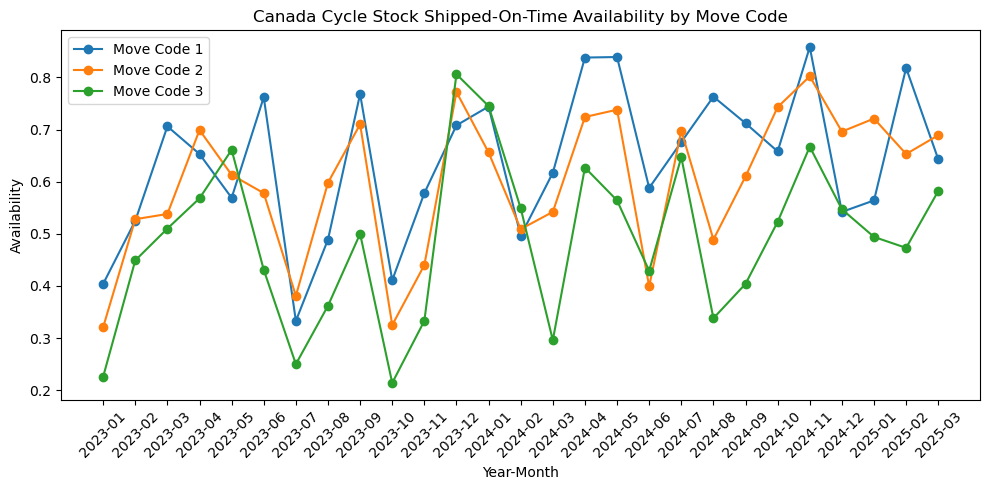

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for mc in availability_pivot_ca.columns:
    plt.plot(
        availability_pivot_ca.index,
        availability_pivot_ca[mc],
        marker="o",
        label=f"Move Code {mc}"
    )

plt.title("Canada Cycle Stock Shipped-On-Time Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


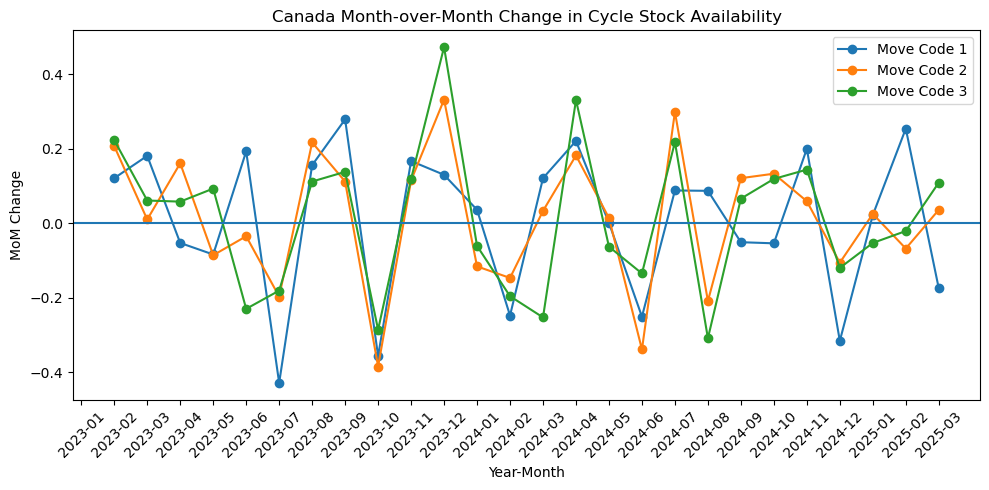

In [19]:
plt.figure(figsize=(10, 5))

for mc in availability_mom_change_ca.columns:
    plt.plot(
        availability_mom_change_ca.index,
        availability_mom_change_ca[mc],
        marker="o",
        label=f"Move Code {mc}"
    )

plt.axhline(0)
plt.title("Canada Month-over-Month Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


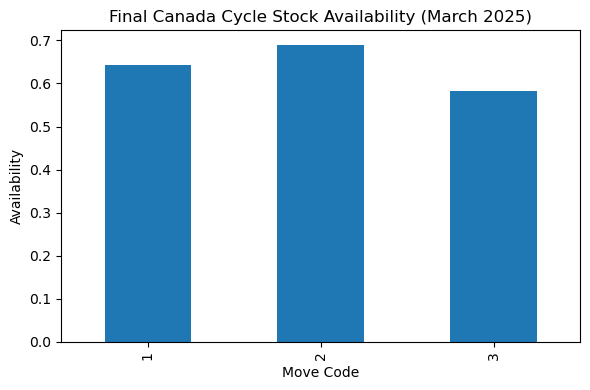

In [20]:
plt.figure(figsize=(6, 4))

final_availability_ca.plot(kind="bar")

plt.title("Final Canada Cycle Stock Availability (March 2025)")
plt.xlabel("Move Code")
plt.ylabel("Availability")
plt.tight_layout()
plt.show()


In [21]:
from pathlib import Path

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

fig = availability_pivot_ca.plot(figsize=(10, 5)).get_figure()
fig.suptitle("Canada Cycle Stock Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "ca_availability_trend.png", dpi=300)
plt.close(fig)

fig = availability_mom_change_ca.plot(figsize=(10, 5)).get_figure()
plt.axhline(0)
fig.suptitle("Canada MoM Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "ca_availability_mom.png", dpi=300)
plt.close(fig)


In [2]:
from pathlib import Path

OUT_DIR = Path("outputs/ca")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR


WindowsPath('outputs/ca')

In [5]:
import pandas as pd

df_ca = pd.read_excel(r"C:\Users\Russellko\Google Drive\CA_Parts_Sales_Data_202503.xlsx")

df_ca.shape


(13819, 18)

In [6]:
analysis_ca = df_ca[
    (df_ca["wh_dispatch_date"] >= "2023-01-01") &
    (df_ca["wh_dispatch_date"] <= "2025-03-31") &
    (df_ca["move_code"].isin([1, 2, 3]))
].copy()

analysis_ca.shape


(7916, 18)

In [7]:
analysis_ca["year_month"] = analysis_ca["wh_dispatch_date"].dt.to_period("M").astype(str)

analysis_ca[["wh_dispatch_date", "year_month"]].head()


,wh_dispatch_date,year_month
6,2023-01-09,2023-01
7,2023-01-09,2023-01
20,2023-01-06,2023-01
24,2023-01-06,2023-01
32,2023-01-19,2023-01


In [8]:
analysis_ca["sla_met"] = analysis_ca["so_to_dispatch_days"] <= 2

analysis_ca["sla_met"].value_counts()


sla_met
True     5313
False    2603
Name: count, dtype: int64

In [9]:
availability_monthly_ca = (
    analysis_ca
    .groupby(["year_month", "move_code"])
    .agg(
        total_lines=("sla_met", "count"),
        shipped_on_time=("sla_met", "sum")
    )
    .assign(
        availability_pct=lambda x: x["shipped_on_time"] / x["total_lines"]
    )
    .reset_index()
)

availability_monthly_ca.head()


,year_month,move_code,total_lines,shipped_on_time,availability_pct
0,2023-01,1,104,60,0.576923
1,2023-01,2,84,37,0.440476
2,2023-01,3,31,9,0.290323
3,2023-02,1,120,78,0.650000
4,2023-02,2,89,55,0.617978


In [10]:
cycle_codes = [1, 2, 3]

availability_pivot_ca = (
    availability_monthly_ca
    .query("move_code in @cycle_codes")
    .pivot(index="year_month", columns="move_code", values="availability_pct")
    .sort_index()
    .round(3)
)

availability_pivot_ca.tail()


move_code,1,2,3
year_month,,,
2024-11,0.866,0.838,0.712
2024-12,0.588,0.774,0.640
2025-01,0.638,0.752,0.543
2025-02,0.836,0.663,0.582
2025-03,0.674,0.697,0.582


In [11]:
import matplotlib.pyplot as plt

fig = availability_pivot_ca.plot(figsize=(10, 5)).get_figure()
fig.suptitle("Canada Cycle Stock Shipped-On-Time Availability by Move Code")
plt.xlabel("Year-Month")
plt.ylabel("Availability")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "availability_trend.png", dpi=300)
plt.close(fig)

"saved", str(OUT_DIR / "availability_trend.png")


('saved', 'outputs\\ca\\availability_trend.png')

In [12]:
availability_mom_change_ca = availability_pivot_ca.diff().round(3)

fig = availability_mom_change_ca.plot(figsize=(10, 5)).get_figure()
plt.axhline(0)
fig.suptitle("Canada Month-over-Month Change in Cycle Stock Availability")
plt.xlabel("Year-Month")
plt.ylabel("MoM Change")
plt.xticks(rotation=45)
fig.tight_layout()
fig.savefig(OUT_DIR / "availability_mom.png", dpi=300)
plt.close(fig)

"saved", str(OUT_DIR / "availability_mom.png")


('saved', 'outputs\\ca\\availability_mom.png')